In [2]:
import sys
import pathlib

import numpy as np
import pandas as pd
import polars as pl
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../../")
from utils.io_utils import load_configs, load_profiles
from utils.data_utils import split_meta_and_features

In [3]:
def calculate_emd_per_treatment(
    profiles_df, reference_df, feature_cols, treatment_col="Metadata_treatment"
):
    """
    Calculate EMD for each treatment across all features.

    Parameters
    ----------
    profiles_df : pl.DataFrame
        Profiles containing treatments to compare
    reference_df : pl.DataFrame
        Reference profiles (e.g., DMSO control)
    feature_cols : list
        List of feature column names
    treatment_col : str
        Column name for treatment identifier

    Returns
    -------
    pl.DataFrame
        EMD scores per treatment per feature
    """
    results = []

    # Get unique treatments
    treatments = profiles_df[treatment_col].unique().to_list()

    for treatment in treatments:
        # Filter treatment profiles
        treatment_df = profiles_df.filter(pl.col(treatment_col) == treatment)

        # Calculate EMD for each feature
        for feature in feature_cols:
            # Get feature values
            treatment_values = treatment_df[feature].to_numpy()
            reference_values = reference_df[feature].to_numpy()

            # Skip if either is empty or all NaN
            if len(treatment_values) == 0 or len(reference_values) == 0:
                continue

            # Remove NaN values
            treatment_values = treatment_values[~np.isnan(treatment_values)]
            reference_values = reference_values[~np.isnan(reference_values)]

            if len(treatment_values) == 0 or len(reference_values) == 0:
                continue

            # Calculate EMD
            emd = wasserstein_distance(treatment_values, reference_values)

            results.append(
                {
                    "treatment": treatment,
                    "compartment": feature.split("_")[0],
                    "feature": feature,
                    "emd_score": emd,
                }
            )

    return pl.DataFrame(results)

In [4]:
# set CFRet screem directory
cfret_screen_dir = pathlib.Path("./results/cfret-screen/").resolve(strict=True)

# set signature path
signature_path = (cfret_screen_dir / "CFRet-screen-signatures.json").resolve(
    strict=True
)

# set cfret profile paths
cfret_profile_paths = (
    cfret_screen_dir / "cfret_screen_treatment_clustered.parquet"
).resolve(strict=True)

In [5]:
# load profiles and signatures
cfret_profiles = load_profiles(cfret_profile_paths)
cfret_meta, cfret_feats = split_meta_and_features(cfret_profiles)

cfret_signatures = load_configs(signature_path)
on_sigs = cfret_signatures["on_signatures"]
off_sigs = cfret_signatures["off_signatures"]

In [6]:
# replace DMSO in the "Metadata_treatment" column with with "DMSO_heart_9"
cfret_profiles = cfret_profiles.with_columns(
    pl.when(pl.col("Metadata_treatment") == "DMSO")
    .then(pl.lit("DMSO_heart_9"))
    .otherwise(pl.col("Metadata_treatment"))
    .alias("Metadata_treatment")
)
cfret_profiles.head()

Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,Metadata_cell_id,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_Zernike_4_0,Cytoplasm_AreaShape_Zernike_5_1,Cytoplasm_AreaShape_Zernike_6_0,Cytoplasm_AreaShape_Zernike_6_2,Cytoplasm_AreaShape_Zernike_7_1,Cytoplasm_AreaShape_Zernike_7_3,Cytoplasm_AreaShape_Zernike_8_0,Cytoplasm_AreaShape_Zernike_8_2,Cytoplasm_AreaShape_Zernike_9_1,Cytoplasm_AreaShape_Zernike_9_3,Cytoplasm_AreaShape_Zernike_9_5,Cytoplasm_AreaShape_Zernike_9_7,Cytoplasm_Correlation_Correlation_ER_Hoechst,Cytoplasm_Correlation_Correlation_ER_PM,…,Nuclei_Texture_Correlation_Hoechst_3_02_256,Nuclei_Texture_Correlation_Hoechst_3_03_256,Nuclei_Texture_Correlation_Mitochondria_3_00_256,Nuclei_Texture_Correlation_Mitochondria_3_01_256,Nuclei_Texture_Correlation_Mitochondria_3_02_256,Nuclei_Texture_Correlation_Mitochondria_3_03_256,Nuclei_Texture_Correlation_PM_3_00_256,Nuclei_Texture_Correlation_PM_3_01_256,Nuclei_Texture_Correlation_PM_3_02_256,Nuclei_Texture_Correlation_PM_3_03_256,Nuclei_Texture_DifferenceEntropy_Hoechst_3_00_256,Nuclei_Texture_DifferenceEntropy_Hoechst_3_02_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_01_256,Nuclei_Texture_InfoMeas1_ER_3_02_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_PM_3_00_256,Nuclei_Texture_InfoMeas1_PM_3_01_256,Nuclei_Texture_InfoMeas1_PM_3_02_256,Nuclei_Texture_InfoMeas1_PM_3_03_256,Nuclei_Texture_InfoMeas2_PM_3_00_256,Nuclei_Texture_InfoMeas2_PM_3_01_256,Nuclei_Texture_InfoMeas2_PM_3_02_256,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_01_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_02_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_03_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumEntropy_PM_3_01_256,Metadata_cluster_id,Metadata_cluster_n_cells,Metadata_treatment_n_cells,Metadata_cluster_ratio
str,i64,i64,str,str,str,str,f64,f64,f64,f64,i64,i64,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,u32,u32,f64
"""B""",2,7,"""healthy""",null,"""DMSO_heart_11""",null,870.048176,222.975912,883.760337,261.61621,8,2,"""localhost240927060001""","""B02""",1,1,3,3,"""f07""","""12575616795011807720""",-0.751363,0.572923,-0.397076,0.280466,-0.842051,0.921933,-0.808205,-0.152162,-0.576562,1.018035,-0.555971,1.136591,-1.010685,-0.580809,0.296295,0.374481,…,0.776713,-0.060115,-0.47829,0.369701,0.664598,-0.595822,-0.779385,-1.10438,0.019679,-0.081576,0.899131,0.131613,0.288529,-0.396068,-1.475314,0.104475,0.605291,0.480656,-0.418191,0.05484,-0.245545,-0.194699,0.449148,0.153167,-1.314356,-0.527268,-0.28336,-0.966427,-0.028467,0.025132,0.531559,0.161083,-0.084311,"""DMSO_heart_11_louvain_3""",324,1720,18.837209
"""B""",2,7,"""healthy""",null,"""DMSO_heart_11""",null,372.665138,78.150612,422.940605,121.357251,9,3,"""localhost240927060001""","""B02""",1,1,3,3,"""f08""","""3793444334871218055""",-1.315906,1.653718,-0.660428,-1.684414,-0.408983,-0.805361,-1.386725,-1.901982,-0.170266,-0.830062,-1.194093,-1.405091,-1.373065,-1.294781,0.279446,0.891917,…,0.260714,-0.725359,0.799276,1.3109,0.532934,0.074106,0.416485,

In [12]:
cfret_profiles[
    ["Metadata_heart_number", "Metadata_cell_type", "Metadata_heart_failure_type"]
].unique()

Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type
i64,str,str
7,"""healthy""",null
19,"""failing""","""dilated_cardiomyopathy"""


In [8]:
# top 5 compounds
lowest_ranked_compound = ["UCD-0001844"]
top5_compounds = [
    "UCD-0159283",
    "UCD-0159257",
    "UCD-0159258",
    "UCD-0001016",
    "UCD-0017999",
]
poscon = "DMSO_heart_11"  # this is the healthy CF cells control

# filter the dataframe to top5 compounds and the positive control
negcon_profiels_df = cfret_profiles.filter(pl.col("Metadata_treatment") == poscon)
cfret_profiles_top5 = cfret_profiles.filter(
    pl.col("Metadata_treatment").is_in(top5_compounds + lowest_ranked_compound)
)

In [9]:
# calculate EMD scores per feature set of both profiles
feature_emd_scores = calculate_emd_per_treatment(
    cfret_profiles_top5,
    negcon_profiels_df,
    cfret_feats,
    treatment_col="Metadata_treatment",
)
feature_emd_scores

# Extract measurement type (second element after split)
feature_emd_scores = feature_emd_scores.with_columns(
    pl.col("feature").str.split("_").list.get(1).alias("measurement")
)
feature_emd_scores.head()

treatment,compartment,feature,emd_score,measurement
str,str,str,f64,str
"""UCD-0159258""","""Cytoplasm""","""Cytoplasm_AreaShape_Area""",0.998697,"""AreaShape"""
"""UCD-0159258""","""Cytoplasm""","""Cytoplasm_AreaShape_MajorAxisL…",0.271384,"""AreaShape"""
"""UCD-0159258""","""Cytoplasm""","""Cytoplasm_AreaShape_Zernike_4_…",0.126555,"""AreaShape"""
"""UCD-0159258""","""Cytoplasm""","""Cytoplasm_AreaShape_Zernike_5_…",0.053286,"""AreaShape"""
"""UCD-0159258""","""Cytoplasm""","""Cytoplasm_AreaShape_Zernike_6_…",0.288622,"""AreaShape"""


In [10]:
# make another dataframe where we group by treatment and take the aggregate score based on compartment
compartment_emd_scores = (
    feature_emd_scores.group_by(["treatment", "compartment"])
    .agg(
        [
            pl.col("emd_score").mean().alias("mean_emd"),
            pl.col("emd_score").median().alias("median_emd"),
            pl.col("emd_score").std().alias("std_emd"),
            (pl.col("emd_score").std() / pl.col("emd_score").count().sqrt()).alias(
                "sem_emd"
            ),
            pl.col("emd_score").min().alias("min_emd"),
            pl.col("emd_score").max().alias("max_emd"),
            pl.col("feature").count().alias("n_features"),
        ]
    )
    .sort(["treatment", "compartment"])
)

compartment_emd_scores

treatment,compartment,mean_emd,median_emd,std_emd,sem_emd,min_emd,max_emd,n_features
str,str,f64,f64,f64,f64,f64,f64,u32
"""UCD-0001016""","""Cells""",0.294924,0.220987,0.256716,0.02226,0.026045,1.477391,133
"""UCD-0001016""","""Cytoplasm""",0.331699,0.255961,0.251591,0.021574,0.032069,1.697175,136
"""UCD-0001016""","""Nuclei""",0.251182,0.17661,0.213719,0.014927,0.031478,1.318134,205
"""UCD-0001844""","""Cells""",0.909662,0.530217,0.985999,0.085497,0.06076,5.501433,133
"""UCD-0001844""","""Cytoplasm""",1.116444,0.690016,1.171671,0.10047,0.061449,5.74974,136
…,…,…,…,…,…,…,…,…
"""UCD-0159258""","""Cytoplasm""",0.412862,0.281223,0.345336,0.029612,0.035866,2.006365,136
"""UCD-0159258""","""Nuclei""",0.243684,0.197629,0.208561,0.014567,0.02736,1.612168,205
"""UCD-0159283""","""Cells""",0.214996,0.191733,0.128931,0.01118,0.025743,0.59864,133


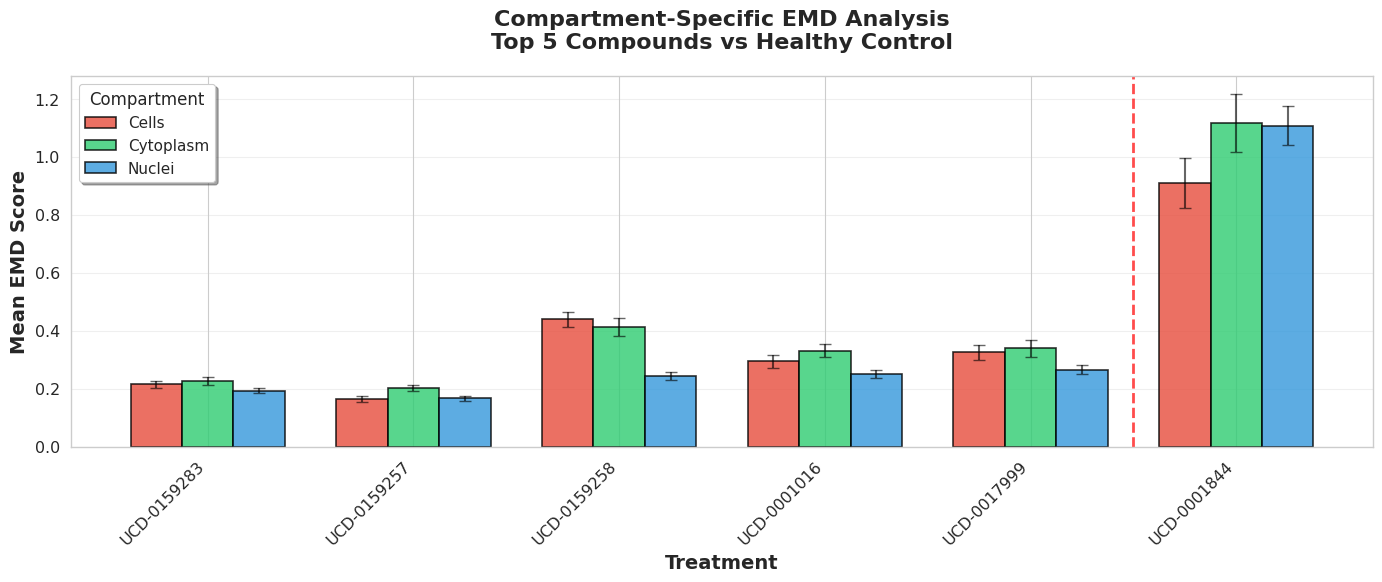

Figure saved to: /home/erikserrano/Projects/buscar/notebooks/2.cfret-analysis/results/cfret-screen/compartment_emd_barplot.png


In [22]:
# Prepare data
plot_df = compartment_emd_scores.to_pandas()

# Define treatment order
treatment_order = [
    "UCD-0159283",
    "UCD-0159257",
    "UCD-0159258",
    "UCD-0001016",
    "UCD-0017999",
] + lowest_ranked_compound

# Convert treatment to categorical with specified order
plot_df["treatment"] = pd.Categorical(
    plot_df["treatment"], categories=treatment_order, ordered=True
)

# Create publication-ready grouped bar plot using matplotlib
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# Define compartment colors and order
compartment_colors = {"Cells": "#e74c3c", "Cytoplasm": "#2ecc71", "Nuclei": "#3498db"}
compartment_order = ["Cells", "Cytoplasm", "Nuclei"]

# Width of bars and positions
width = 0.25
x_pos = np.arange(len(treatment_order))

# Create grouped bars with SEM error bars
for i, compartment in enumerate(compartment_order):
    comp_data = plot_df[plot_df["compartment"] == compartment].sort_values("treatment")

    ax.bar(
        x_pos + (i - 1) * width,
        comp_data["mean_emd"],
        width,
        label=compartment,
        color=compartment_colors[compartment],
        edgecolor="black",
        linewidth=1.2,
        alpha=0.8,
        yerr=comp_data["sem_emd"],  # Add SEM error bars
        capsize=4,
        error_kw={"linewidth": 1.5, "ecolor": "black", "alpha": 0.6},
    )

# Add vertical line to separate top 5 from worst compound
ax.axvline(x=4.5, color="red", linestyle="--", linewidth=2, alpha=0.7)

# Customize plot
ax.set_xlabel("Treatment", fontsize=14, fontweight="bold")
ax.set_ylabel("Mean EMD Score", fontsize=14, fontweight="bold")
ax.set_title(
    "Compartment-Specific EMD Analysis\nTop 5 Compounds vs Healthy Control",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Set x-axis
ax.set_xticks(x_pos)
ax.set_xticklabels(treatment_order, rotation=45, ha="right")

# Legend
ax.legend(
    title="Compartment",
    loc="upper left",
    frameon=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12,
)

# Grid
ax.grid(True, alpha=0.3, axis="y")
ax.set_axisbelow(True)

plt.tight_layout()
fig_path = cfret_screen_dir / "compartment_emd_barplot.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.savefig(fig_path.with_suffix(".pdf"), bbox_inches="tight")
plt.show()

print(f"Figure saved to: {fig_path}")

In [23]:
# next lets measure the on and off morphology signature scores
on_emd_scores = feature_emd_scores.filter(pl.col("feature").is_in(on_sigs))
off_emd_scores = feature_emd_scores.filter(pl.col("feature").is_in(off_sigs))

# now aggregate both on and off emd scores by treatment and get the mean
on_sig_compartment_emd_scores = (
    on_emd_scores.group_by(["treatment", "compartment"])
    .agg(
        [
            pl.col("emd_score").mean().alias("mean_emd"),
            pl.col("emd_score").median().alias("median_emd"),
            pl.col("emd_score").std().alias("std_emd"),
            (pl.col("emd_score").std() / pl.col("emd_score").count().sqrt()).alias(
                "sem_emd"
            ),
            pl.col("emd_score").min().alias("min_emd"),
            pl.col("emd_score").max().alias("max_emd"),
            pl.col("emd_score").count().alias("n_features"),  # This is the count
        ]
    )
    .sort(["treatment", "compartment"])
)

# now aggregate both on and off emd scores by treatment and get the mean
off_sig_compartment_emd_scores = (
    off_emd_scores.group_by(["treatment", "compartment"])
    .agg(
        [
            pl.col("emd_score").mean().alias("mean_emd"),
            pl.col("emd_score").median().alias("median_emd"),
            pl.col("emd_score").std().alias("std_emd"),
            (pl.col("emd_score").std() / pl.col("emd_score").count().sqrt()).alias(
                "sem_emd"
            ),
            pl.col("emd_score").min().alias("min_emd"),  # Added missing min_emd
            pl.col("emd_score").max().alias("max_emd"),
            pl.col("emd_score").count().alias("n_features"),  # This is the count
        ]
    )
    .sort(["treatment", "compartment"])
)

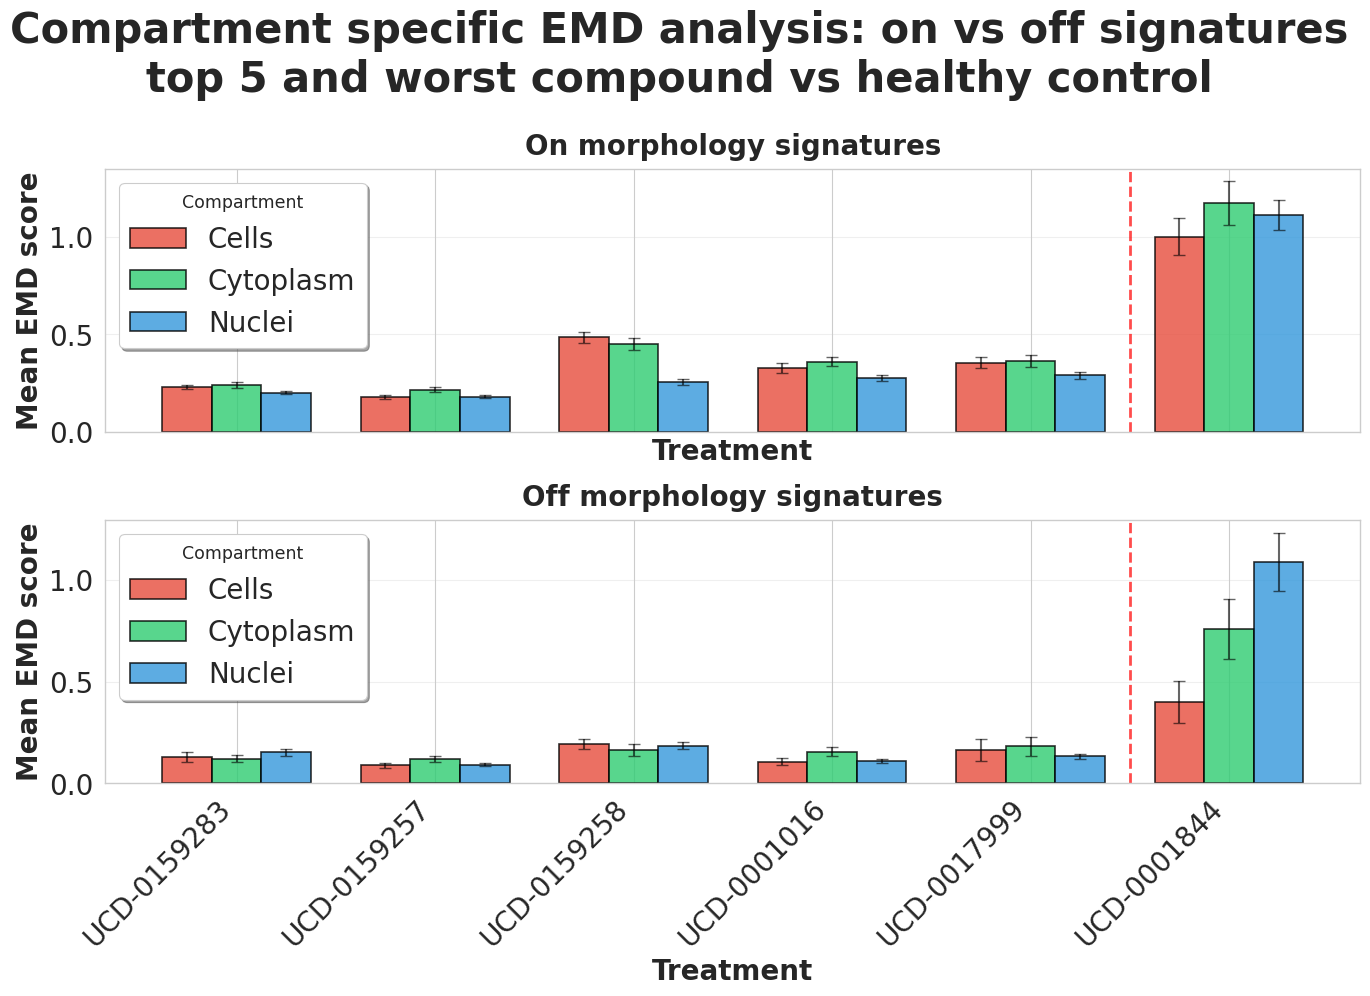

Figure saved to: /home/erikserrano/Projects/buscar/notebooks/2.cfret-analysis/results/cfret-screen/on_off_signature_emd_barplot.png


In [24]:
# Prepare data for on and off signatures
on_plot_df = on_sig_compartment_emd_scores.to_pandas()
off_plot_df = off_sig_compartment_emd_scores.to_pandas()

# Define treatment order
treatment_order = [
    "UCD-0159283",
    "UCD-0159257",
    "UCD-0159258",
    "UCD-0001016",
    "UCD-0017999",
] + lowest_ranked_compound

# Convert treatment to categorical with specified order
on_plot_df["treatment"] = pd.Categorical(
    on_plot_df["treatment"], categories=treatment_order, ordered=True
)
off_plot_df["treatment"] = pd.Categorical(
    off_plot_df["treatment"], categories=treatment_order, ordered=True
)

# Create publication-ready grouped bar plots
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Define compartment colors and order
compartment_colors = {"Cells": "#e74c3c", "Cytoplasm": "#2ecc71", "Nuclei": "#3498db"}
compartment_order = ["Cells", "Cytoplasm", "Nuclei"]

# Width of bars and positions
width = 0.25
x_pos = np.arange(len(treatment_order))

# Plot 1: ON signatures - GROUPED bars with SEM
for i, compartment in enumerate(compartment_order):
    comp_data = on_plot_df[on_plot_df["compartment"] == compartment].sort_values(
        "treatment"
    )

    ax1.bar(
        x_pos + (i - 1) * width,
        comp_data["mean_emd"],
        width,
        label=compartment,
        color=compartment_colors[compartment],
        edgecolor="black",
        linewidth=1.2,
        alpha=0.8,
        yerr=comp_data["sem_emd"],
        capsize=4,
        error_kw={"linewidth": 1.5, "ecolor": "black", "alpha": 0.6},
    )

# Add vertical line to separate top 5 from worst compound
ax1.axvline(x=4.5, color="red", linestyle="--", linewidth=2, alpha=0.7)

ax1.set_xlabel("Treatment", fontsize=20, fontweight="bold")
ax1.set_ylabel("Mean EMD score", fontsize=20, fontweight="bold")
ax1.set_title("On morphology signatures", fontsize=20, fontweight="bold", pad=10)
ax1.legend(
    title="Compartment", loc="upper left", frameon=True, shadow=True, fontsize=20
)
ax1.grid(True, alpha=0.3, axis="y")
ax1.set_axisbelow(True)
ax1.set_xticks(x_pos)
ax1.tick_params(axis="both", labelsize=20)

# Plot 2: OFF signatures - GROUPED bars with SEM
for i, compartment in enumerate(compartment_order):
    comp_data = off_plot_df[off_plot_df["compartment"] == compartment].sort_values(
        "treatment"
    )

    ax2.bar(
        x_pos + (i - 1) * width,
        comp_data["mean_emd"],
        width,
        label=compartment,
        color=compartment_colors[compartment],
        edgecolor="black",
        linewidth=1.2,
        alpha=0.8,
        yerr=comp_data["sem_emd"],
        capsize=4,
        error_kw={"linewidth": 1.5, "ecolor": "black", "alpha": 0.6},
    )

# Add vertical line to separate top 5 from worst compound
ax2.axvline(x=4.5, color="red", linestyle="--", linewidth=2, alpha=0.7)

ax2.set_xlabel("Treatment", fontsize=20, fontweight="bold")
ax2.set_ylabel("Mean EMD score", fontsize=20, fontweight="bold")
ax2.set_title("Off morphology signatures", fontsize=20, fontweight="bold", pad=10)
ax2.legend(
    title="Compartment", loc="upper left", frameon=True, shadow=True, fontsize=20
)
ax2.grid(True, alpha=0.3, axis="y")
ax2.set_axisbelow(True)

# Set x-axis labels
ax2.set_xticks(x_pos)
ax2.set_xticklabels(treatment_order, rotation=45, ha="right")
ax2.tick_params(axis="both", labelsize=20)

# Overall title
fig.suptitle(
    "Compartment specific EMD analysis: on vs off signatures\ntop 5 and worst compound vs healthy control",
    fontsize=30,
    fontweight="bold",
    y=0.995,
)

plt.tight_layout()
fig_path = cfret_screen_dir / "on_off_signature_emd_barplot.png"
plt.savefig(fig_path, dpi=600, bbox_inches="tight")
plt.savefig(fig_path.with_suffix(".pdf"), bbox_inches="tight")
plt.show()

print(f"Figure saved to: {fig_path}")

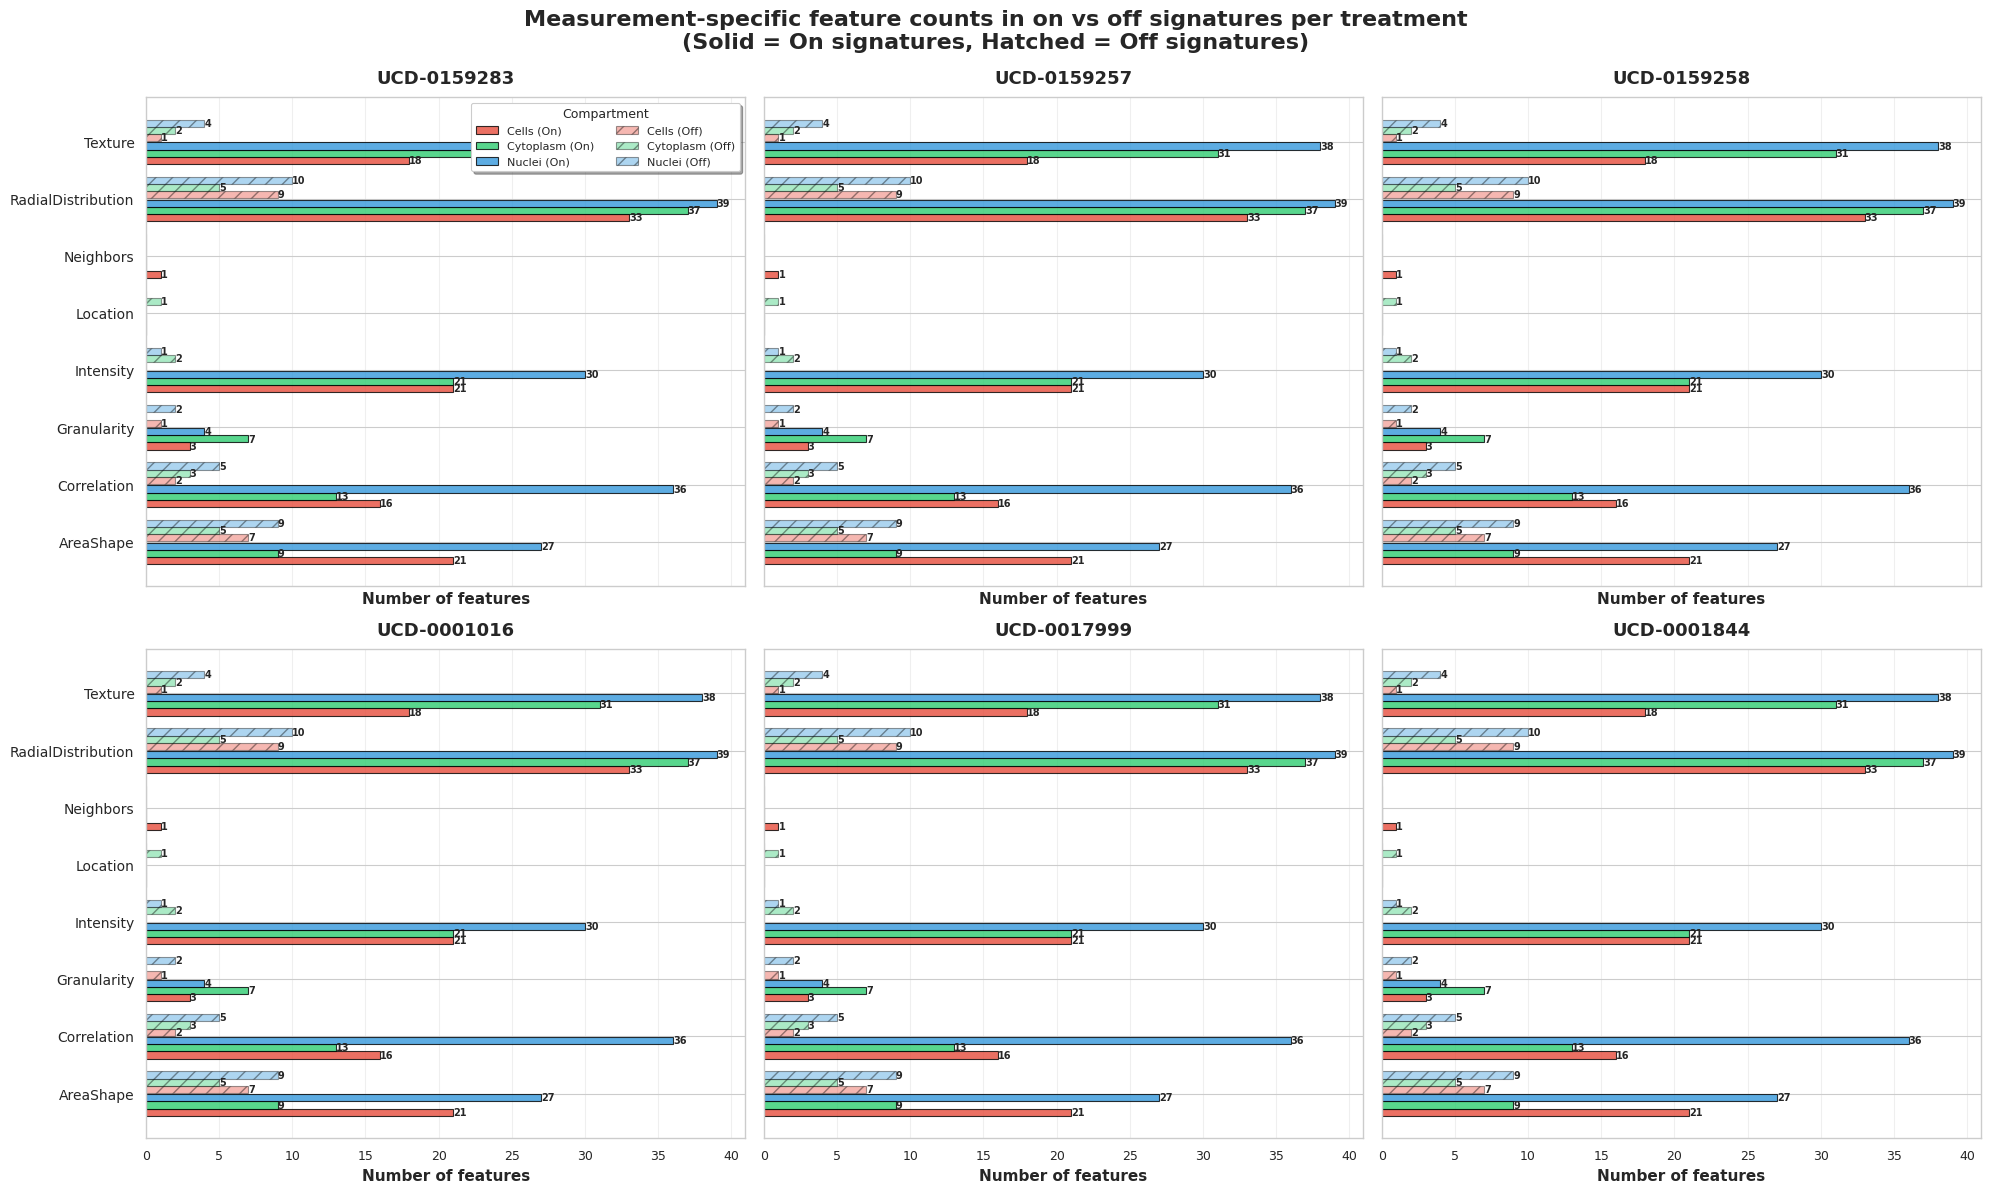

Figure saved to: /home/erikserrano/Projects/buscar/notebooks/2.cfret-analysis/results/cfret-screen/signature_measurement_counts_by_treatment_grouped.png

On signature measurement counts:
shape: (114, 4)
┌─────────────┬────────────────────┬─────────────┬────────────┐
│ treatment   ┆ measurement        ┆ compartment ┆ n_features │
│ ---         ┆ ---                ┆ ---         ┆ ---        │
│ str         ┆ str                ┆ str         ┆ u32        │
╞═════════════╪════════════════════╪═════════════╪════════════╡
│ UCD-0001016 ┆ AreaShape          ┆ Cells       ┆ 21         │
│ UCD-0001016 ┆ AreaShape          ┆ Cytoplasm   ┆ 9          │
│ UCD-0001016 ┆ AreaShape          ┆ Nuclei      ┆ 27         │
│ UCD-0001016 ┆ Correlation        ┆ Cells       ┆ 16         │
│ UCD-0001016 ┆ Correlation        ┆ Cytoplasm   ┆ 13         │
│ …           ┆ …                  ┆ …           ┆ …          │
│ UCD-0159283 ┆ RadialDistribution ┆ Cytoplasm   ┆ 37         │
│ UCD-0159283 ┆ RadialDistrib

In [27]:
# Calculate counts per signature type, treatment, and measurement
on_measurement_counts = (
    on_emd_scores.group_by(["treatment", "measurement", "compartment"])
    .agg([pl.col("feature").n_unique().alias("n_features")])
    .sort(["treatment", "measurement", "compartment"])
)

off_measurement_counts = (
    off_emd_scores.group_by(["treatment", "measurement", "compartment"])
    .agg([pl.col("feature").n_unique().alias("n_features")])
    .sort(["treatment", "measurement", "compartment"])
)

# Prepare data for plotting
on_counts_df = on_measurement_counts.to_pandas()
off_counts_df = off_measurement_counts.to_pandas()

# Define treatment order
treatment_order = [
    "UCD-0159283",
    "UCD-0159257",
    "UCD-0159258",
    "UCD-0001016",
    "UCD-0017999",
] + lowest_ranked_compound

# Define compartment colors and order
compartment_colors = {"Cells": "#e74c3c", "Cytoplasm": "#2ecc71", "Nuclei": "#3498db"}
compartment_order = ["Cells", "Cytoplasm", "Nuclei"]

# Create publication-ready figure with HORIZONTAL layout (2 rows x 3 cols)
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.0)

fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True, sharex=True)
axes = axes.flatten()

# Plot each treatment
for idx, treatment in enumerate(treatment_order):
    ax = axes[idx]

    # Filter data for this treatment
    on_treatment = on_counts_df[on_counts_df["treatment"] == treatment]
    off_treatment = off_counts_df[off_counts_df["treatment"] == treatment]

    # Get all unique measurements for this treatment
    measurements = sorted(
        set(on_treatment["measurement"].unique())
        | set(off_treatment["measurement"].unique())
    )

    # Create separate data for On and Off signatures
    y_pos_on = np.arange(len(measurements)) * 2  # Space for on signatures
    y_pos_off = (
        np.arange(len(measurements)) * 2 + 0.8
    )  # Space for off signatures (offset)

    height = 0.25  # Height of each compartment bar

    # Plot ON signatures - grouped by compartment
    for i, compartment in enumerate(compartment_order):
        on_comp_counts = []
        for measurement in measurements:
            count = on_treatment[
                (on_treatment["measurement"] == measurement)
                & (on_treatment["compartment"] == compartment)
            ]["n_features"].sum()
            on_comp_counts.append(count)

        bars = ax.barh(
            y_pos_on + (i - 1) * height,
            on_comp_counts,
            height=height,
            label=f"{compartment} (On)" if idx == 0 else "",
            color=compartment_colors[compartment],
            edgecolor="black",
            linewidth=0.8,
            alpha=0.8,
        )

        # Add count labels
        for bar, count in zip(bars, on_comp_counts):
            if count > 0:
                ax.text(
                    count,
                    bar.get_y() + bar.get_height() / 2.0,
                    f"{int(count)}",
                    ha="left",
                    va="center",
                    fontsize=7,
                    fontweight="bold",
                )

    # Plot OFF signatures - grouped by compartment
    for i, compartment in enumerate(compartment_order):
        off_comp_counts = []
        for measurement in measurements:
            count = off_treatment[
                (off_treatment["measurement"] == measurement)
                & (off_treatment["compartment"] == compartment)
            ]["n_features"].sum()
            off_comp_counts.append(count)

        bars = ax.barh(
            y_pos_off + (i - 1) * height,
            off_comp_counts,
            height=height,
            label=f"{compartment} (Off)" if idx == 0 else "",
            color=compartment_colors[compartment],
            edgecolor="black",
            linewidth=0.8,
            alpha=0.4,  # Lighter for off signatures
            hatch="//",  # Pattern to distinguish from on
        )

        # Add count labels
        for bar, count in zip(bars, off_comp_counts):
            if count > 0:
                ax.text(
                    count,
                    bar.get_y() + bar.get_height() / 2.0,
                    f"{int(count)}",
                    ha="left",
                    va="center",
                    fontsize=7,
                    fontweight="bold",
                )

    # Set y-axis labels - show measurement names
    y_ticks = (y_pos_on + y_pos_off) / 2  # Center between on and off
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(measurements, fontsize=10)

    # Customize subplot
    ax.set_xlabel("Number of features", fontsize=11, fontweight="bold")
    ax.set_title(f"{treatment}", fontsize=13, fontweight="bold", pad=10)
    ax.grid(True, alpha=0.3, axis="x")
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", labelsize=9)

    # Add legend only on first subplot
    if idx == 0:
        ax.legend(
            loc="upper right",
            frameon=True,
            shadow=True,
            fontsize=8,
            title="Compartment",
            title_fontsize=9,
            ncol=2,
        )

# Overall title
fig.suptitle(
    "Measurement-specific feature counts in on vs off signatures per treatment\n(Solid = On signatures, Hatched = Off signatures)",
    fontsize=16,
    fontweight="bold",
    y=0.99,
)

plt.tight_layout()
fig_path = cfret_screen_dir / "signature_measurement_counts_by_treatment_grouped.png"
plt.savefig(fig_path, dpi=600, bbox_inches="tight")
plt.savefig(fig_path.with_suffix(".pdf"), bbox_inches="tight")
plt.show()

print(f"Figure saved to: {fig_path}")
print("\nOn signature measurement counts:")
print(on_measurement_counts)
print("\nOff signature measurement counts:")
print(off_measurement_counts)

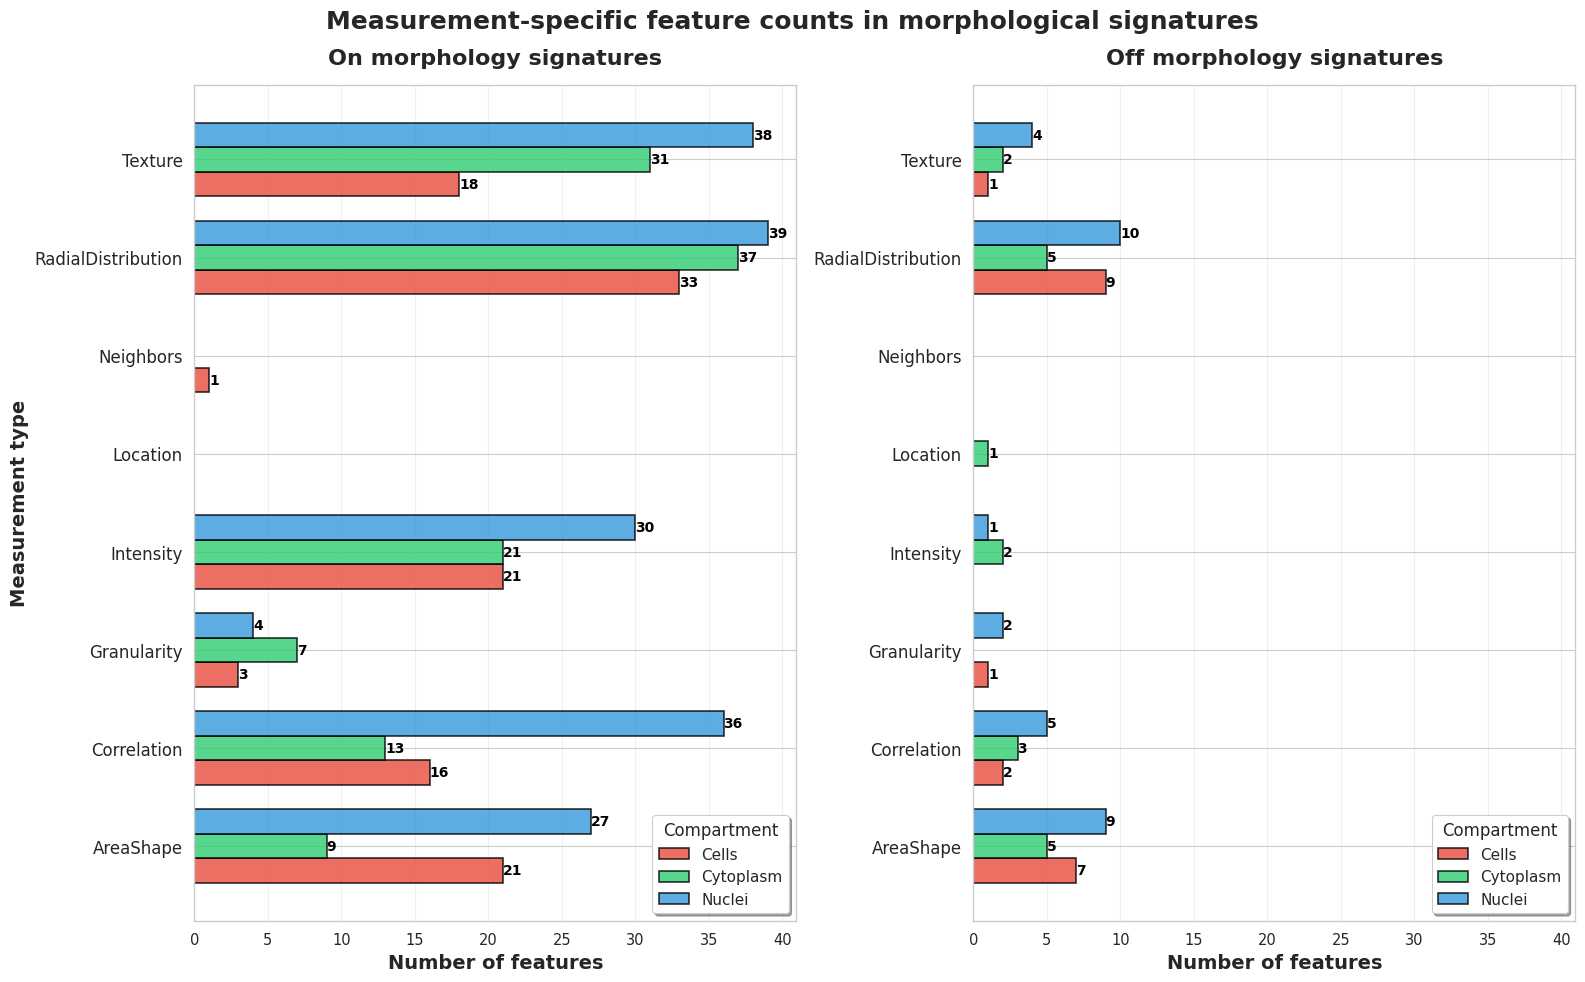

In [36]:
# Calculate counts per signature type and measurement (aggregating across all treatments)
on_measurement_counts = (
    on_emd_scores.group_by(["measurement", "compartment"])
    .agg([pl.col("feature").n_unique().alias("n_features")])
    .sort(["measurement", "compartment"])
)

off_measurement_counts = (
    off_emd_scores.group_by(["measurement", "compartment"])
    .agg([pl.col("feature").n_unique().alias("n_features")])
    .sort(["measurement", "compartment"])
)

# Prepare data for plotting
on_counts_df = on_measurement_counts.to_pandas()
off_counts_df = off_measurement_counts.to_pandas()

# Define compartment colors and order
compartment_colors = {"Cells": "#e74c3c", "Cytoplasm": "#2ecc71", "Nuclei": "#3498db"}
compartment_order = ["Cells", "Cytoplasm", "Nuclei"]

# Create publication-ready figure with 2 subplots
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10), sharex=True)

# Get all unique measurements
all_measurements = sorted(
    set(on_counts_df["measurement"].unique())
    | set(off_counts_df["measurement"].unique())
)

# Height of bars and positions
y_pos = np.arange(len(all_measurements))
height = 0.25

# Plot 1: ON signatures (horizontal bars)
for i, compartment in enumerate(compartment_order):
    on_comp_counts = []
    for measurement in all_measurements:
        count = on_counts_df[
            (on_counts_df["measurement"] == measurement)
            & (on_counts_df["compartment"] == compartment)
        ]["n_features"].sum()
        on_comp_counts.append(count)

    bars = ax1.barh(
        y_pos + (i - 1) * height,
        on_comp_counts,
        height,
        label=compartment,
        color=compartment_colors[compartment],
        edgecolor="black",
        linewidth=1.2,
        alpha=0.8,
    )

    # Add count labels
    for bar, count in zip(bars, on_comp_counts):
        if count > 0:
            ax1.text(
                count,
                bar.get_y() + bar.get_height() / 2.0,
                f"{int(count)}",
                ha="left",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

# Plot 2: OFF signatures (horizontal bars)
for i, compartment in enumerate(compartment_order):
    off_comp_counts = []
    for measurement in all_measurements:
        count = off_counts_df[
            (off_counts_df["measurement"] == measurement)
            & (off_counts_df["compartment"] == compartment)
        ]["n_features"].sum()
        off_comp_counts.append(count)

    bars = ax2.barh(
        y_pos + (i - 1) * height,
        off_comp_counts,
        height,
        label=compartment,
        color=compartment_colors[compartment],
        edgecolor="black",
        linewidth=1.2,
        alpha=0.8,
    )

    # Add count labels
    for bar, count in zip(bars, off_comp_counts):
        if count > 0:
            ax2.text(
                count,
                bar.get_y() + bar.get_height() / 2.0,
                f"{int(count)}",
                ha="left",
                va="center",
                fontsize=10,
                fontweight="bold",
                color="black",
            )

# Customize subplot 1 (ON signatures)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(all_measurements, fontsize=12)
ax1.set_xlabel("Number of features", fontsize=14, fontweight="bold")
ax1.set_ylabel("Measurement type", fontsize=14, fontweight="bold")
ax1.set_title("On morphology signatures", fontsize=16, fontweight="bold", pad=15)
ax1.legend(
    title="Compartment",
    loc="lower right",
    frameon=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12,
)
ax1.grid(True, alpha=0.3, axis="x")
ax1.set_axisbelow(True)

# Customize subplot 2 (OFF signatures)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(all_measurements, fontsize=12)
ax2.set_xlabel("Number of features", fontsize=14, fontweight="bold")
ax2.set_title("Off morphology signatures", fontsize=16, fontweight="bold", pad=15)
ax2.legend(
    title="Compartment",
    loc="lower right",
    frameon=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12,
)
ax2.grid(True, alpha=0.3, axis="x")
ax2.set_axisbelow(True)

# Overall title
fig.suptitle(
    "Measurement-specific feature counts in morphological signatures",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

plt.tight_layout()
fig_path = cfret_screen_dir / "signature_measurement_counts_on_off.png"
plt.savefig(fig_path, dpi=600, bbox_inches="tight")
plt.savefig(fig_path.with_suffix(".pdf"), bbox_inches="tight")
plt.show()